<div class="alert alert-block alert-success">
  <h2>RSNA Pneumonia Dataset - Exploratory Data Analysis</h2>
</div>

<div class="alert alert-block alert-info">
    <h2>Import Libraries</h2>
</div>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import warnings
from collections import Counter
from scipy import stats

warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette('husl')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

<div class="alert alert-block alert-info">
    <h2>EDA Class Definition</h2>
</div>

In [46]:
class RSNAPneumoniaEDA:
    def __init__(self, base_path, output_dir='eda_outputs'):
        self.base_path = Path(base_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Data paths
        self.train_metadata_path = self.base_path / 'stage2_train_metadata.csv'
        self.test_metadata_path = self.base_path / 'stage2_test_metadata.csv'
        self.train_images_path = self.base_path / 'Training' / 'Images'
        self.train_masks_path = self.base_path / 'Training' / 'Masks'
        self.test_images_path = self.base_path / 'Test'
        
        # DataFrames
        self.train_df = None
        self.test_df = None
        
    def load_data(self):
        print("="  * 80)
        print("LOADING RSNA PNEUMONIA DETECTION DATASET")
        print("=" * 80)
        
        # Load training data
        if self.train_metadata_path.exists():
            self.train_df = pd.read_csv(self.train_metadata_path)
            print(f"\n✓ Training metadata loaded: {len(self.train_df)} records")
            print(f"  Columns: {list(self.train_df.columns)}")
        else:
            print(f"✗ Training metadata not found at {self.train_metadata_path}")
            
        # Load test data
        if self.test_metadata_path.exists():
            self.test_df = pd.read_csv(self.test_metadata_path)
            print(f"\n✓ Test metadata loaded: {len(self.test_df)} records")
            print(f"  Columns: {list(self.test_df.columns)}")
        else:
            print(f"✗ Test metadata not found at {self.test_metadata_path}")
            
        return self
    
    def basic_statistics(self):
        print("\n" + "=" * 80)
        print("BASIC DATASET STATISTICS")
        print("=" * 80)
        
        if self.train_df is not None:
            print("\n--- TRAINING DATA ---")
            print(f"Total records: {len(self.train_df)}")
            print(f"Unique patients: {self.train_df['patientId'].nunique()}")
            
            # Target distribution
            print(f"\nTarget Distribution:")
            target_counts = self.train_df['Target'].value_counts()
            for target, count in target_counts.items():
                pct = (count / len(self.train_df)) * 100
                label = "Pneumonia (Lung Opacity)" if target == 1 else "No Pneumonia"
                print(f"  {label}: {count} ({pct:.2f}%)")
            
            # Class distribution
            if 'class' in self.train_df.columns:
                print(f"\nClass Distribution:")
                class_counts = self.train_df['class'].value_counts()
                for cls, count in class_counts.items():
                    pct = (count / len(self.train_df)) * 100
                    print(f"  {cls}: {count} ({pct:.2f}%)")
            
            # Bounding box statistics
            bbox_present = self.train_df[['x', 'y', 'width', 'height']].notna().all(axis=1).sum()
            print(f"\nBounding Boxes:")
            print(f"  Records with bounding boxes: {bbox_present}")
            print(f"  Records without bounding boxes: {len(self.train_df) - bbox_present}")
            
            # Patient-level statistics
            patient_counts = self.train_df.groupby('patientId').size()
            print(f"\nPatient-Level Statistics:")
            print(f"  Patients with single record: {(patient_counts == 1).sum()}")
            print(f"  Patients with multiple records: {(patient_counts > 1).sum()}")
            print(f"  Max bounding boxes per patient: {patient_counts.max()}")
            
            # Demographics
            if 'age' in self.train_df.columns:
                print(f"\nAge Statistics:")
                print(f"  Mean age: {self.train_df['age'].mean():.1f} years")
                print(f"  Median age: {self.train_df['age'].median():.1f} years")
                print(f"  Age range: {self.train_df['age'].min():.0f} - {self.train_df['age'].max():.0f} years")
            
            if 'sex' in self.train_df.columns:
                print(f"\nSex Distribution:")
                sex_counts = self.train_df['sex'].value_counts()
                for sex, count in sex_counts.items():
                    pct = (count / len(self.train_df)) * 100
                    print(f"  {sex}: {count} ({pct:.2f}%)")
            
            # Modality and Position
            if 'modality' in self.train_df.columns:
                print(f"\nModality Distribution:")
                print(self.train_df['modality'].value_counts())
            
            if 'position' in self.train_df.columns:
                print(f"\nPosition Distribution:")
                print(self.train_df['position'].value_counts())
        
        if self.test_df is not None:
            print("\n--- TEST DATA ---")
            print(f"Total records: {len(self.test_df)}")
            print(f"Unique patients: {self.test_df['patientId'].nunique()}")
    
    def plot_target_distribution(self):
        if self.train_df is None:
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Target distribution - bar plot
        target_counts = self.train_df['Target'].value_counts()
        labels = ['No Pneumonia', 'Pneumonia']
        colors = ['#66B2FF', '#FF6B6B']
        
        axes[0].bar(labels, target_counts.values, color=colors, edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].set_title('Target Distribution (All Records)', fontsize=14, fontweight='bold')
        axes[0].grid(alpha=0.3, axis='y')
        
        # Add count labels on bars
        for i, (label, count) in enumerate(zip(labels, target_counts.values)):
            pct = (count / len(self.train_df)) * 100
            axes[0].text(i, count, f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold')
        
        # Patient-level target distribution
        patient_target = self.train_df.groupby('patientId')['Target'].max()
        patient_counts = patient_target.value_counts()
        
        axes[1].bar(labels, patient_counts.values, color=colors, edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel('Count', fontsize=12)
        axes[1].set_title('Target Distribution (Unique Patients)', fontsize=14, fontweight='bold')
        axes[1].grid(alpha=0.3, axis='y')
        
        # Add count labels
        for i, (label, count) in enumerate(zip(labels, patient_counts.values)):
            pct = (count / len(patient_target)) * 100
            axes[1].text(i, count, f'{count}\n({pct:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def plot_class_distribution(self):
        if self.train_df is None or 'class' not in self.train_df.columns:
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Class distribution
        class_counts = self.train_df['class'].value_counts()
        
        axes[0].barh(range(len(class_counts)), class_counts.values, 
                    color='skyblue', edgecolor='black')
        axes[0].set_yticks(range(len(class_counts)))
        axes[0].set_yticklabels(class_counts.index)
        axes[0].set_xlabel('Count', fontsize=12)
        axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
        axes[0].grid(alpha=0.3, axis='x')
        
        # Add count labels
        for i, count in enumerate(class_counts.values):
            pct = (count / len(self.train_df)) * 100
            axes[0].text(count, i, f'  {count} ({pct:.1f}%)', 
                        va='center', fontweight='bold')
        
        # Pie chart
        colors_pie = sns.color_palette('pastel', len(class_counts))
        axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
                   colors=colors_pie, startangle=90, textprops={'fontsize': 10})
        axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

In [47]:
# Age distribution methods
def plot_age_distribution(self):
    if self.train_df is None or 'age' not in self.train_df.columns:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overall age distribution
    axes[0, 0].hist(self.train_df['age'], bins=30, color='skyblue', 
                   edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(self.train_df['age'].mean(), color='red', 
                      linestyle='--', linewidth=2, label=f"Mean: {self.train_df['age'].mean():.1f}")
    axes[0, 0].axvline(self.train_df['age'].median(), color='green', 
                      linestyle='--', linewidth=2, label=f"Median: {self.train_df['age'].median():.1f}")
    axes[0, 0].set_xlabel('Age (years)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Age Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Age by Target
    for target in [0, 1]:
        subset = self.train_df[self.train_df['Target'] == target]['age']
        label = 'Pneumonia' if target == 1 else 'No Pneumonia'
        axes[0, 1].hist(subset, bins=25, alpha=0.6, label=label, edgecolor='black')
    
    axes[0, 1].set_xlabel('Age (years)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Age Distribution by Target', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Age box plot by Target
    self.train_df.boxplot(column='age', by='Target', ax=axes[1, 0], 
                         patch_artist=True, grid=True)
    axes[1, 0].set_xlabel('Target (0=No Pneumonia, 1=Pneumonia)', fontsize=12)
    axes[1, 0].set_ylabel('Age (years)', fontsize=12)
    axes[1, 0].set_title('Age Distribution Box Plot by Target', fontsize=14, fontweight='bold')
    plt.sca(axes[1, 0])
    plt.xticks([1, 2], ['No Pneumonia', 'Pneumonia'])
    
    # Age groups
    age_bins = [0, 18, 35, 50, 65, 100]
    age_labels = ['0-18', '19-35', '36-50', '51-65', '66+']
    self.train_df['age_group'] = pd.cut(self.train_df['age'], bins=age_bins, labels=age_labels)
    
    age_group_counts = self.train_df.groupby(['age_group', 'Target']).size().unstack(fill_value=0)
    age_group_counts.plot(kind='bar', ax=axes[1, 1], color=['#66B2FF', '#FF6B6B'], 
                         edgecolor='black', width=0.8)
    axes[1, 1].set_xlabel('Age Group', fontsize=12)
    axes[1, 1].set_ylabel('Count', fontsize=12)
    axes[1, 1].set_title('Target Distribution by Age Group', fontsize=14, fontweight='bold')
    axes[1, 1].legend(['No Pneumonia', 'Pneumonia'])
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# Add method to class
RSNAPneumoniaEDA.plot_age_distribution = plot_age_distribution

In [48]:
# Sex distribution methods
def plot_sex_distribution(self):
    if self.train_df is None or 'sex' not in self.train_df.columns:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Overall sex distribution
    sex_counts = self.train_df['sex'].value_counts()
    colors = ['#FF9999', '#66B2FF']
    axes[0].bar(sex_counts.index, sex_counts.values, color=colors, 
               edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Sex Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3, axis='y')
    
    for i, (sex, count) in enumerate(sex_counts.items()):
        pct = (count / len(self.train_df)) * 100
        axes[0].text(i, count, f'{count}\n({pct:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold')
    
    # By Target
    sex_target = self.train_df.groupby(['sex', 'Target']).size().unstack(fill_value=0)
    sex_target.plot(kind='bar', ax=axes[1], color=['#66B2FF', '#FF6B6B'], 
                   edgecolor='black', width=0.7)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_xlabel('Sex', fontsize=12)
    axes[1].set_title('Target Distribution by Sex', fontsize=14, fontweight='bold')
    axes[1].legend(['No Pneumonia', 'Pneumonia'])
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(alpha=0.3, axis='y')
    
    # Percentage stacked bar
    sex_target_pct = sex_target.div(sex_target.sum(axis=1), axis=0) * 100
    sex_target_pct.plot(kind='bar', stacked=True, ax=axes[2], 
                       color=['#66B2FF', '#FF6B6B'], edgecolor='black', width=0.7)
    axes[2].set_ylabel('Percentage', fontsize=12)
    axes[2].set_xlabel('Sex', fontsize=12)
    axes[2].set_title('Target Distribution by Sex (Percentage)', fontsize=14, fontweight='bold')
    axes[2].legend(['No Pneumonia', 'Pneumonia'])
    axes[2].tick_params(axis='x', rotation=0)
    axes[2].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(self.output_dir / 'sex_distribution.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {self.output_dir / 'sex_distribution.png'}")
    plt.show()

# Add method to class
RSNAPneumoniaEDA.plot_sex_distribution = plot_sex_distribution

In [49]:
# Modality and position methods
def plot_modality_position(self):
    if self.train_df is None:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Modality distribution
    if 'modality' in self.train_df.columns:
        modality_counts = self.train_df['modality'].value_counts()
        axes[0, 0].bar(modality_counts.index, modality_counts.values, 
                      color='lightcoral', edgecolor='black')
        axes[0, 0].set_ylabel('Count', fontsize=12)
        axes[0, 0].set_xlabel('Modality', fontsize=12)
        axes[0, 0].set_title('Modality Distribution', fontsize=14, fontweight='bold')
        axes[0, 0].grid(alpha=0.3, axis='y')
        
        for i, (mod, count) in enumerate(modality_counts.items()):
            pct = (count / len(self.train_df)) * 100
            axes[0, 0].text(i, count, f'{count}\n({pct:.1f}%)', 
                          ha='center', va='bottom', fontweight='bold')
    
    # Position distribution
    if 'position' in self.train_df.columns:
        position_counts = self.train_df['position'].value_counts()
        axes[0, 1].bar(position_counts.index, position_counts.values, 
                      color='lightgreen', edgecolor='black')
        axes[0, 1].set_ylabel('Count', fontsize=12)
        axes[0, 1].set_xlabel('Position', fontsize=12)
        axes[0, 1].set_title('Position Distribution', fontsize=14, fontweight='bold')
        axes[0, 1].grid(alpha=0.3, axis='y')
        
        for i, (pos, count) in enumerate(position_counts.items()):
            pct = (count / len(self.train_df)) * 100
            axes[0, 1].text(i, count, f'{count}\n({pct:.1f}%)', 
                          ha='center', va='bottom', fontweight='bold')
    
    # By Target
    if 'position' in self.train_df.columns:
        pos_target = self.train_df.groupby(['position', 'Target']).size().unstack(fill_value=0)
        pos_target.plot(kind='bar', ax=axes[1, 0], color=['#66B2FF', '#FF6B6B'], 
                       edgecolor='black', width=0.7)
        axes[1, 0].set_ylabel('Count', fontsize=12)
        axes[1, 0].set_xlabel('Position', fontsize=12)
        axes[1, 0].set_title('Target Distribution by Position', fontsize=14, fontweight='bold')
        axes[1, 0].legend(['No Pneumonia', 'Pneumonia'])
        axes[1, 0].tick_params(axis='x', rotation=0)
        axes[1, 0].grid(alpha=0.3, axis='y')
    
    # By Target (percentage)
    if 'position' in self.train_df.columns:
        pos_target_pct = pos_target.div(pos_target.sum(axis=1), axis=0) * 100
        pos_target_pct.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                           color=['#66B2FF', '#FF6B6B'], edgecolor='black', width=0.7)
        axes[1, 1].set_ylabel('Percentage', fontsize=12)
        axes[1, 1].set_xlabel('Position', fontsize=12)
        axes[1, 1].set_title('Target Distribution by Position (Percentage)', 
                            fontsize=14, fontweight='bold')
        axes[1, 1].legend(['No Pneumonia', 'Pneumonia'])
        axes[1, 1].tick_params(axis='x', rotation=0)
        axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# Add method to class
RSNAPneumoniaEDA.plot_modality_position = plot_modality_position

In [50]:
# Bounding box methods
def plot_bounding_box_analysis(self):
    if self.train_df is None:
        return
    
    # Filter records with bounding boxes
    bbox_df = self.train_df[self.train_df[['x', 'y', 'width', 'height']].notna().all(axis=1)].copy()
    
    if len(bbox_df) == 0:
        print("No bounding box data available")
        return
    
    # Calculate area and aspect ratio
    bbox_df['area'] = bbox_df['width'] * bbox_df['height']
    bbox_df['aspect_ratio'] = bbox_df['width'] / bbox_df['height']
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Width distribution
    axes[0, 0].hist(bbox_df['width'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Width (pixels)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Bounding Box Width Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].axvline(bbox_df['width'].mean(), color='red', linestyle='--', 
                      label=f"Mean: {bbox_df['width'].mean():.1f}")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Height distribution
    axes[0, 1].hist(bbox_df['height'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Height (pixels)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Bounding Box Height Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].axvline(bbox_df['height'].mean(), color='red', linestyle='--', 
                      label=f"Mean: {bbox_df['height'].mean():.1f}")
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Area distribution
    axes[0, 2].hist(bbox_df['area'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[0, 2].set_xlabel('Area (pixels²)', fontsize=12)
    axes[0, 2].set_ylabel('Frequency', fontsize=12)
    axes[0, 2].set_title('Bounding Box Area Distribution', fontsize=14, fontweight='bold')
    axes[0, 2].axvline(bbox_df['area'].mean(), color='red', linestyle='--', 
                      label=f"Mean: {bbox_df['area'].mean():.1f}")
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    
    # Aspect ratio distribution
    axes[1, 0].hist(bbox_df['aspect_ratio'], bins=30, color='plum', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Aspect Ratio (width/height)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Bounding Box Aspect Ratio', fontsize=14, fontweight='bold')
    axes[1, 0].axvline(1.0, color='green', linestyle='--', label='Square (1:1)')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Width vs Height scatter
    axes[1, 1].scatter(bbox_df['width'], bbox_df['height'], alpha=0.5, s=20, c='blue')
    axes[1, 1].set_xlabel('Width (pixels)', fontsize=12)
    axes[1, 1].set_ylabel('Height (pixels)', fontsize=12)
    axes[1, 1].set_title('Width vs Height Scatter', fontsize=14, fontweight='bold')
    axes[1, 1].plot([0, bbox_df['width'].max()], [0, bbox_df['width'].max()], 
                   'r--', label='y=x (square)')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Bounding boxes per patient
    bbox_per_patient = bbox_df.groupby('patientId').size()
    axes[1, 2].hist(bbox_per_patient, bins=range(1, bbox_per_patient.max() + 2), 
                   color='orange', edgecolor='black', alpha=0.7)
    axes[1, 2].set_xlabel('Number of Bounding Boxes', fontsize=12)
    axes[1, 2].set_ylabel('Number of Patients', fontsize=12)
    axes[1, 2].set_title('Bounding Boxes per Patient', fontsize=14, fontweight='bold')
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nBounding Box Statistics:")
    print(f"  Width:  Mean={bbox_df['width'].mean():.1f}, Median={bbox_df['width'].median():.1f}, "
          f"Std={bbox_df['width'].std():.1f}")
    print(f"  Height: Mean={bbox_df['height'].mean():.1f}, Median={bbox_df['height'].median():.1f}, "
          f"Std={bbox_df['height'].std():.1f}")
    print(f"  Area:   Mean={bbox_df['area'].mean():.1f}, Median={bbox_df['area'].median():.1f}")
    print(f"  Aspect Ratio: Mean={bbox_df['aspect_ratio'].mean():.2f}, "
          f"Median={bbox_df['aspect_ratio'].median():.2f}")

# Add method to class
RSNAPneumoniaEDA.plot_bounding_box_analysis = plot_bounding_box_analysis

In [51]:
# Image analysis methods
def analyze_image_properties(self, num_samples=100):
    if not self.train_images_path.exists():
        print(f"Image directory not found: {self.train_images_path}")
        return
    
    print("\n" + "=" * 80)
    print(f"ANALYZING IMAGE PROPERTIES (Sample size: {num_samples})")
    print("=" * 80)
    
    # Get list of images
    image_files = list(self.train_images_path.glob('*.png'))[:num_samples]
    
    if len(image_files) == 0:
        print("No image files found")
        return
    
    image_stats = {
        'width': [],
        'height': [],
        'mean_intensity': [],
        'std_intensity': [],
        'min_intensity': [],
        'max_intensity': []
    }
    
    print(f"Analyzing {len(image_files)} images...")
    for img_file in image_files:
        try:
            img = Image.open(img_file).convert('L')  # Convert to grayscale
            img_array = np.array(img)
            
            image_stats['width'].append(img_array.shape[1])
            image_stats['height'].append(img_array.shape[0])
            image_stats['mean_intensity'].append(img_array.mean())
            image_stats['std_intensity'].append(img_array.std())
            image_stats['min_intensity'].append(img_array.min())
            image_stats['max_intensity'].append(img_array.max())
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    # Convert to DataFrame
    img_df = pd.DataFrame(image_stats)
    
    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Image dimensions
    axes[0, 0].hist(img_df['width'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Width (pixels)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Image Width Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    
    axes[0, 1].hist(img_df['height'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Height (pixels)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Image Height Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    # Aspect ratio
    img_df['aspect_ratio'] = img_df['width'] / img_df['height']
    axes[0, 2].hist(img_df['aspect_ratio'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[0, 2].set_xlabel('Aspect Ratio', fontsize=12)
    axes[0, 2].set_ylabel('Frequency', fontsize=12)
    axes[0, 2].set_title('Image Aspect Ratio Distribution', fontsize=14, fontweight='bold')
    axes[0, 2].grid(alpha=0.3)
    
    # Intensity statistics
    axes[1, 0].hist(img_df['mean_intensity'], bins=20, color='plum', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Mean Intensity', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Mean Pixel Intensity Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].hist(img_df['std_intensity'], bins=20, color='orange', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Std Dev Intensity', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('Pixel Intensity Std Dev Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    # Scatter: mean vs std intensity
    axes[1, 2].scatter(img_df['mean_intensity'], img_df['std_intensity'], 
                      alpha=0.6, s=50, c='blue', edgecolor='black')
    axes[1, 2].set_xlabel('Mean Intensity', fontsize=12)
    axes[1, 2].set_ylabel('Std Dev Intensity', fontsize=12)
    axes[1, 2].set_title('Mean vs Std Dev Intensity', fontsize=14, fontweight='bold')
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nImage Statistics:")
    print(f"  Dimensions: {img_df['width'].mode().values[0]:.0f} x {img_df['height'].mode().values[0]:.0f} "
          f"(most common)")
    print(f"  Width range: {img_df['width'].min():.0f} - {img_df['width'].max():.0f}")
    print(f"  Height range: {img_df['height'].min():.0f} - {img_df['height'].max():.0f}")
    print(f"  Mean intensity: {img_df['mean_intensity'].mean():.2f} ± {img_df['mean_intensity'].std():.2f}")

# Add method to class
RSNAPneumoniaEDA.analyze_image_properties = analyze_image_properties

<div class="alert alert-block alert-info">
    <h2>Run EDA Analysis</h2>
</div>

In [52]:
# Configuration
BASE_PATH = '../archive'  # RSNA dataset
OUTPUT_DIR = 'eda_outputs'
NUM_IMAGE_SAMPLES = 100

In [53]:
# Initialize EDA class
eda = RSNAPneumoniaEDA(base_path=BASE_PATH, output_dir=OUTPUT_DIR)

In [54]:
# Load data
eda.load_data()

LOADING RSNA PNEUMONIA DETECTION DATASET

✓ Training metadata loaded: 30227 records
  Columns: ['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'age', 'sex', 'modality', 'position']

✓ Test metadata loaded: 3000 records
  Columns: ['patientId', 'PredictionString', 'age', 'sex', 'modality', 'position']


In [55]:
# Display basic statistics
eda.basic_statistics()


BASIC DATASET STATISTICS

--- TRAINING DATA ---
Total records: 30227
Unique patients: 26684

Target Distribution:
  No Pneumonia: 20672 (68.39%)
  Pneumonia (Lung Opacity): 9555 (31.61%)

Class Distribution:
  No Lung Opacity / Not Normal: 11821 (39.11%)
  Lung Opacity: 9555 (31.61%)
  Normal: 8851 (29.28%)

Bounding Boxes:
  Records with bounding boxes: 9555
  Records without bounding boxes: 20672

Patient-Level Statistics:
  Patients with single record: 23286
  Patients with multiple records: 3398
  Max bounding boxes per patient: 4

Age Statistics:
  Mean age: 46.8 years
  Median age: 49.0 years
  Age range: 1 - 155 years

Sex Distribution:
  M: 17216 (56.96%)
  F: 13011 (43.04%)

Modality Distribution:
modality
CR    30227
Name: count, dtype: int64

Position Distribution:
position
AP    15297
PA    14930
Name: count, dtype: int64

--- TEST DATA ---
Total records: 3000
Unique patients: 3000


In [56]:
# Preview the data
print("\nFirst 10 records of training data:")
display(eda.train_df.head(10))


First 10 records of training data:


,patientId,x,y,width,height,Target,class,age,sex,modality,position
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F,CR,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F,CR,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M,CR,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M,CR,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F,CR,AP
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,32,F,CR,AP
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,54,M,CR,AP
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,78,M,CR,PA
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,75,M,CR,PA
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,75,M,CR,PA


<div class="alert alert-block alert-info">
    <h2>Generate Visualizations</h2>
</div>

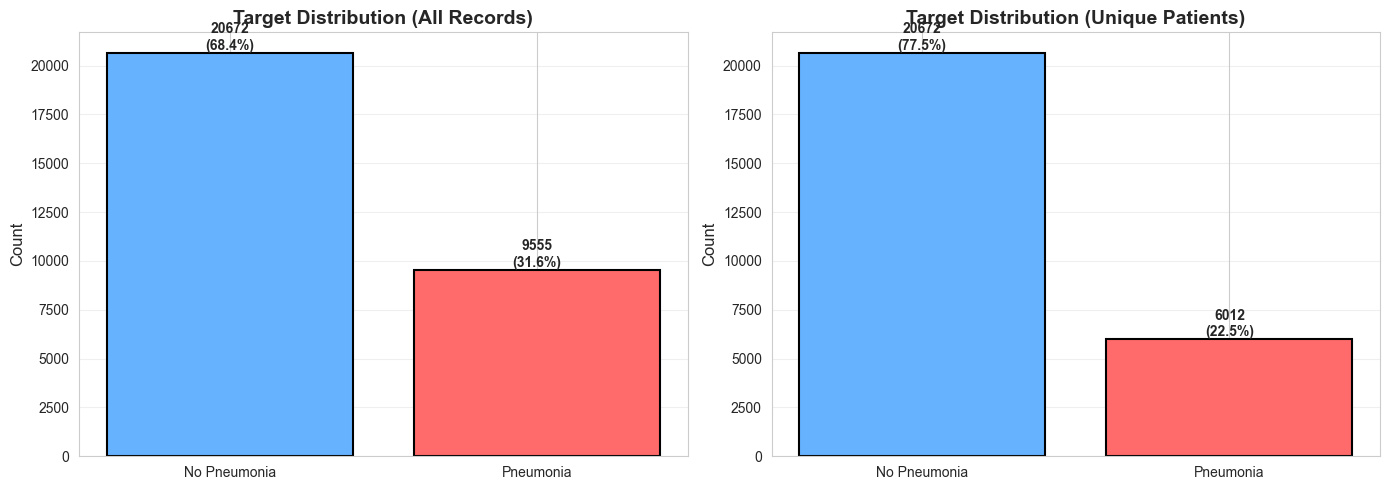

In [57]:
# Target distribution
eda.plot_target_distribution()

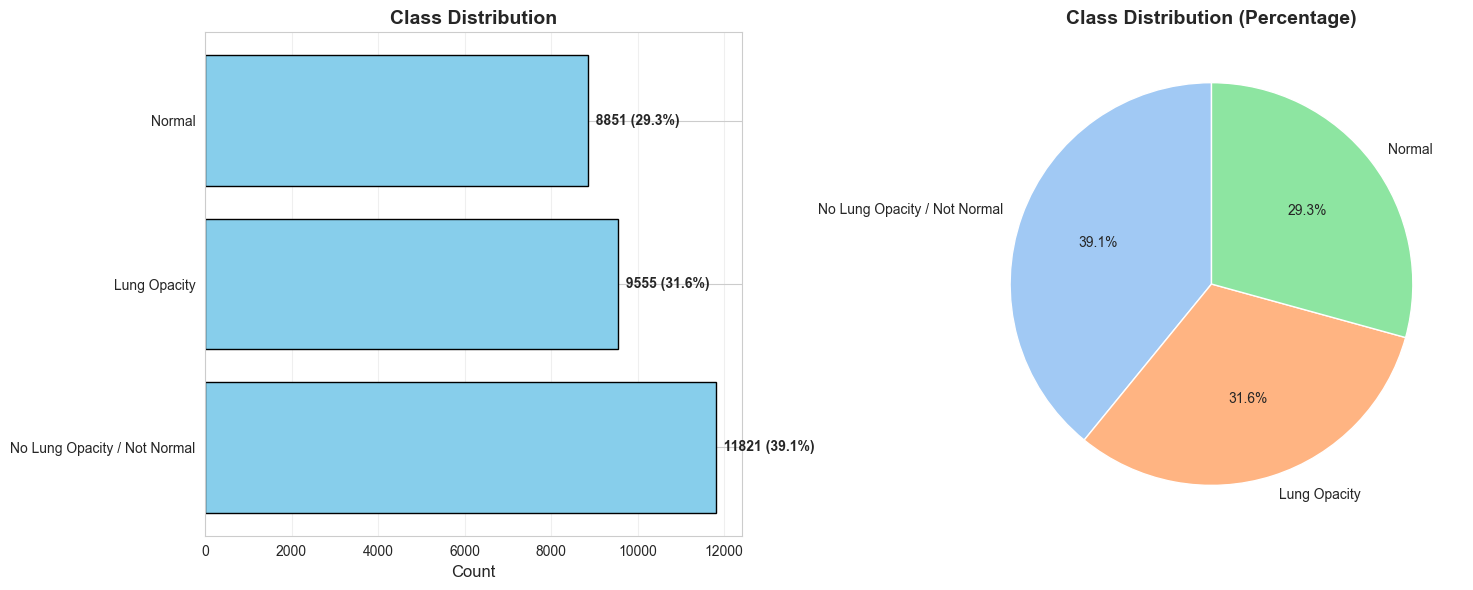

In [58]:
# Class distribution
eda.plot_class_distribution()

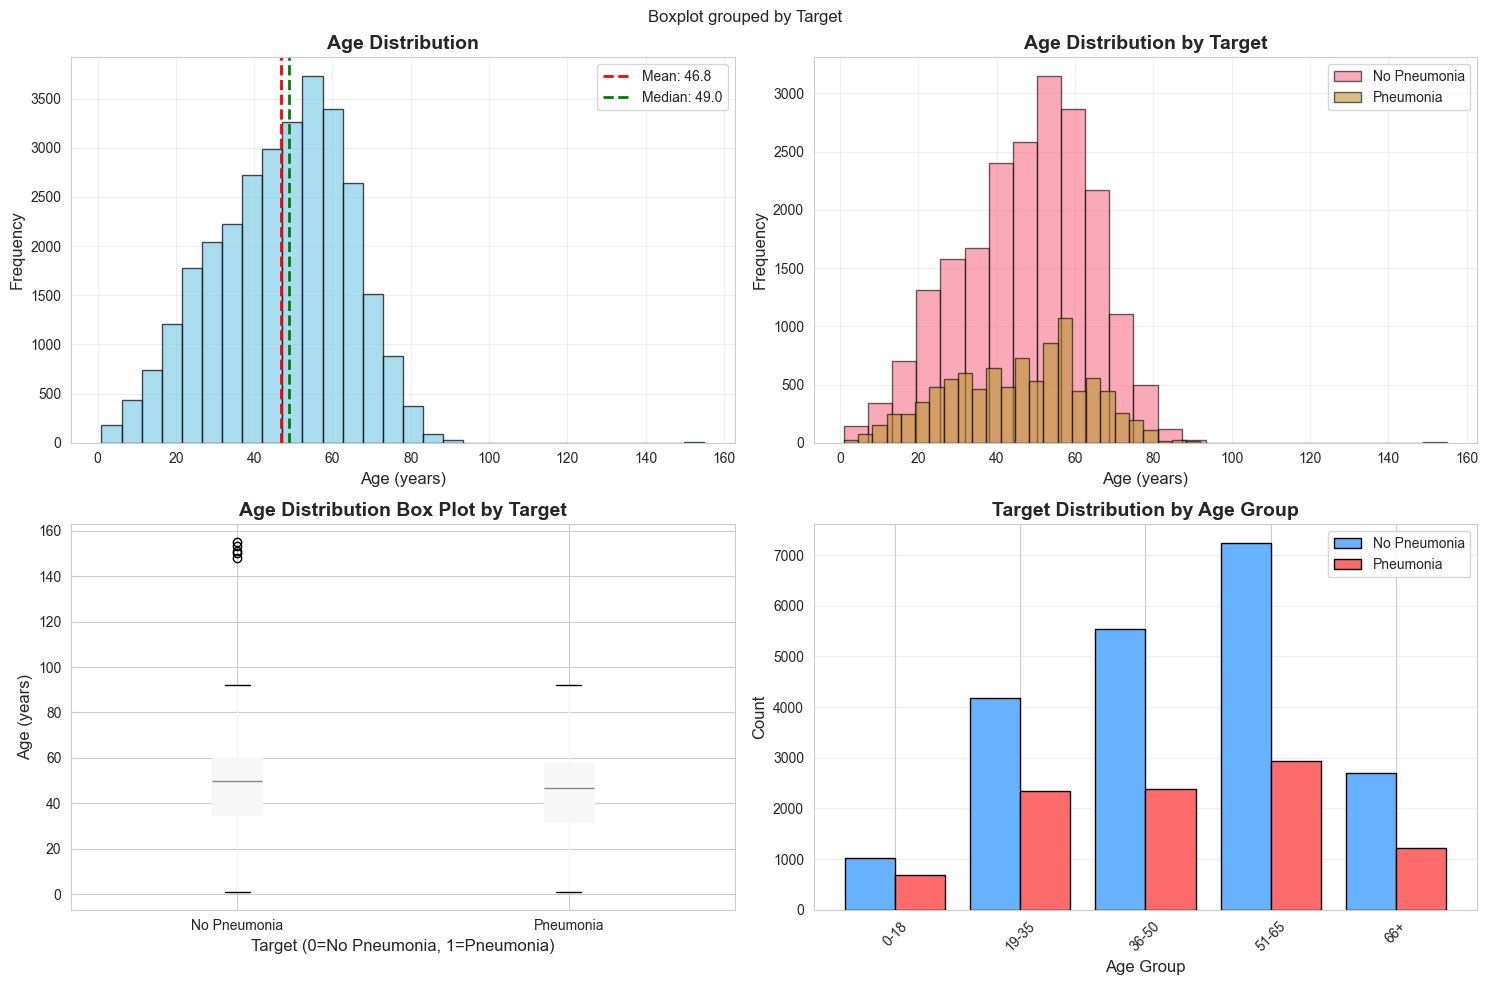

In [59]:
# Age distribution
eda.plot_age_distribution()

✓ Saved: eda_outputs/sex_distribution.png


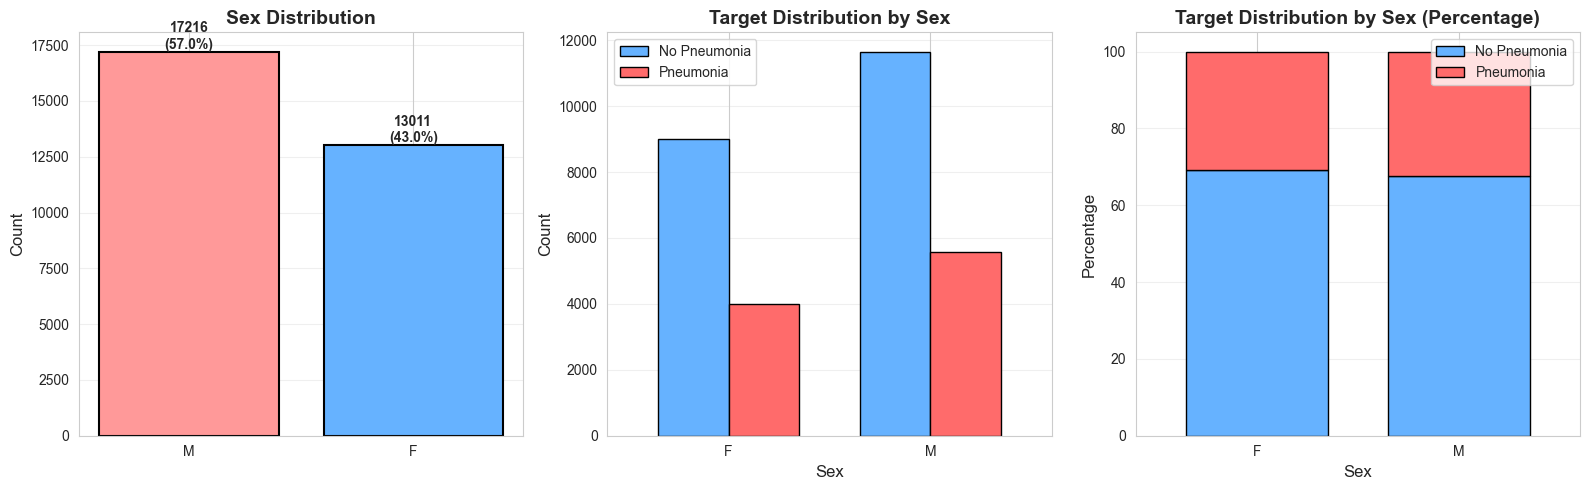

In [60]:
# Sex distribution
eda.plot_sex_distribution()

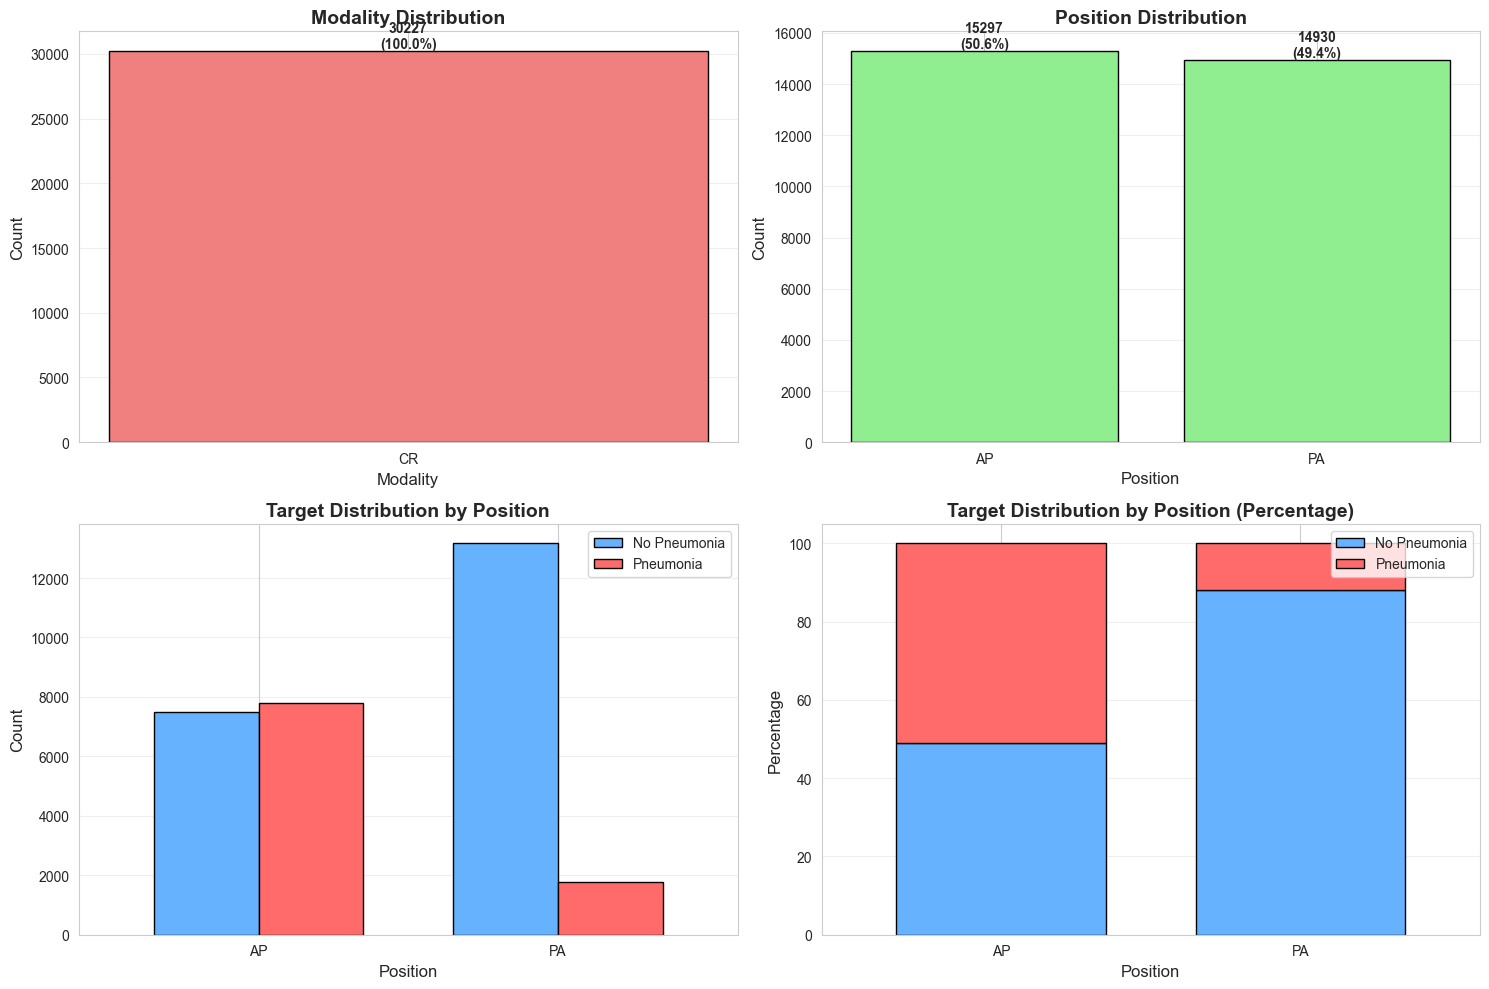

In [61]:
# Modality and position analysis
eda.plot_modality_position()

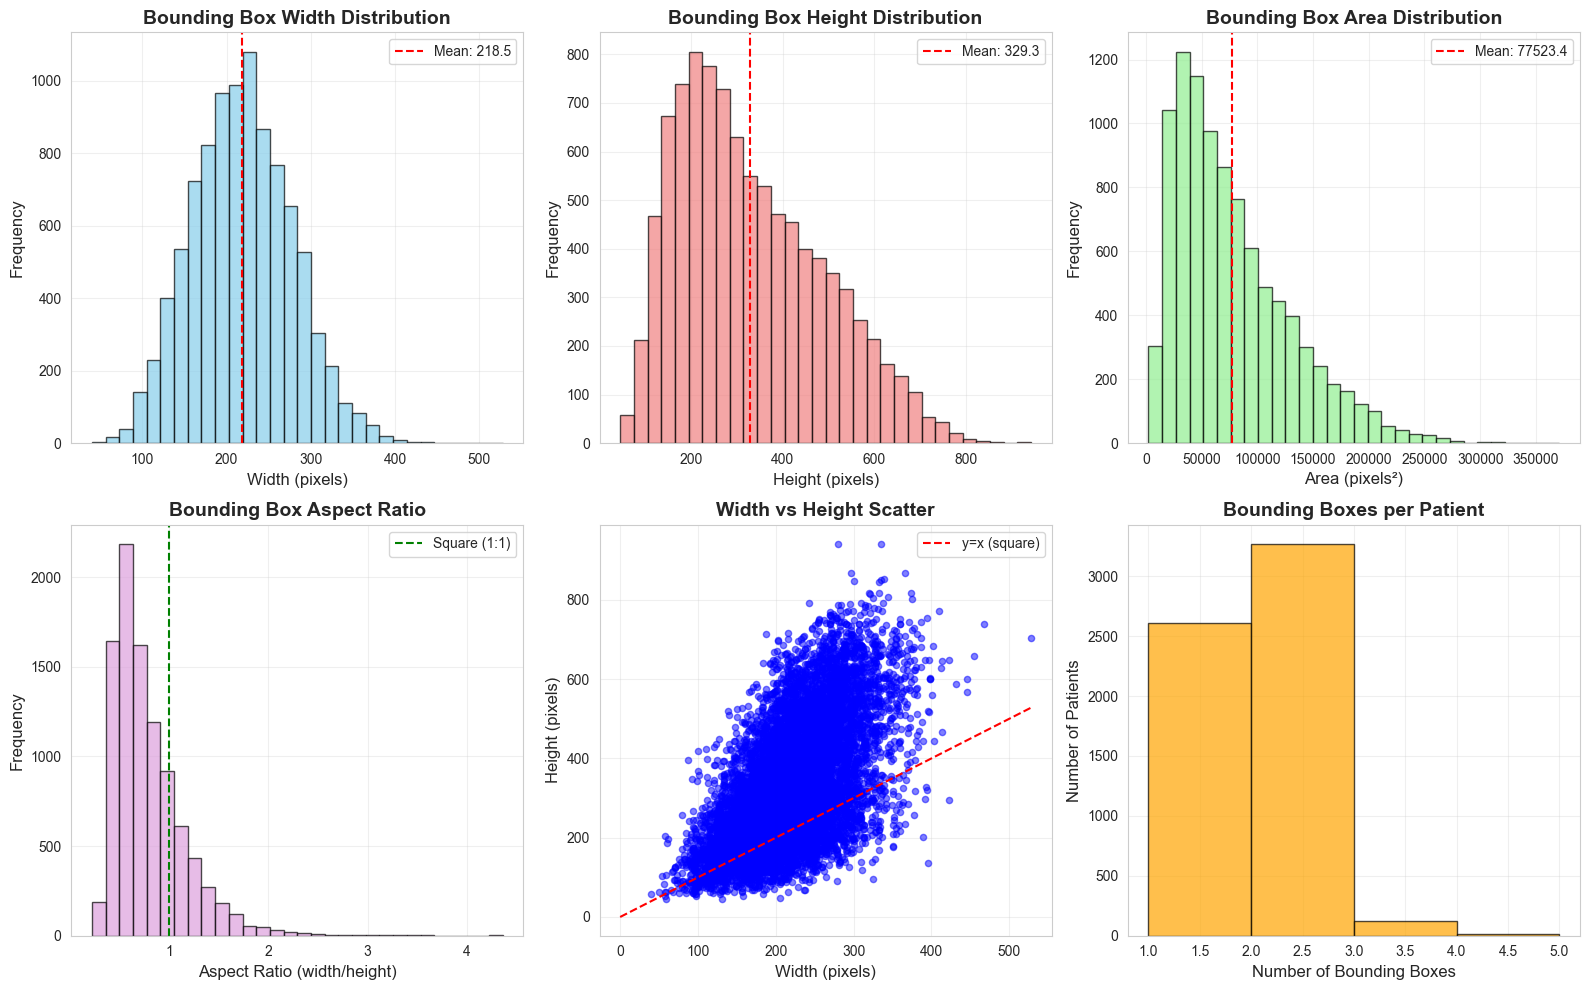


Bounding Box Statistics:
  Width:  Mean=218.5, Median=217.0, Std=59.3
  Height: Mean=329.3, Median=298.0, Std=157.8
  Area:   Mean=77523.4, Median=64829.0
  Aspect Ratio: Mean=0.79, Median=0.69


In [62]:
# Bounding box analysis
eda.plot_bounding_box_analysis()


ANALYZING IMAGE PROPERTIES (Sample size: 100)
Analyzing 100 images...


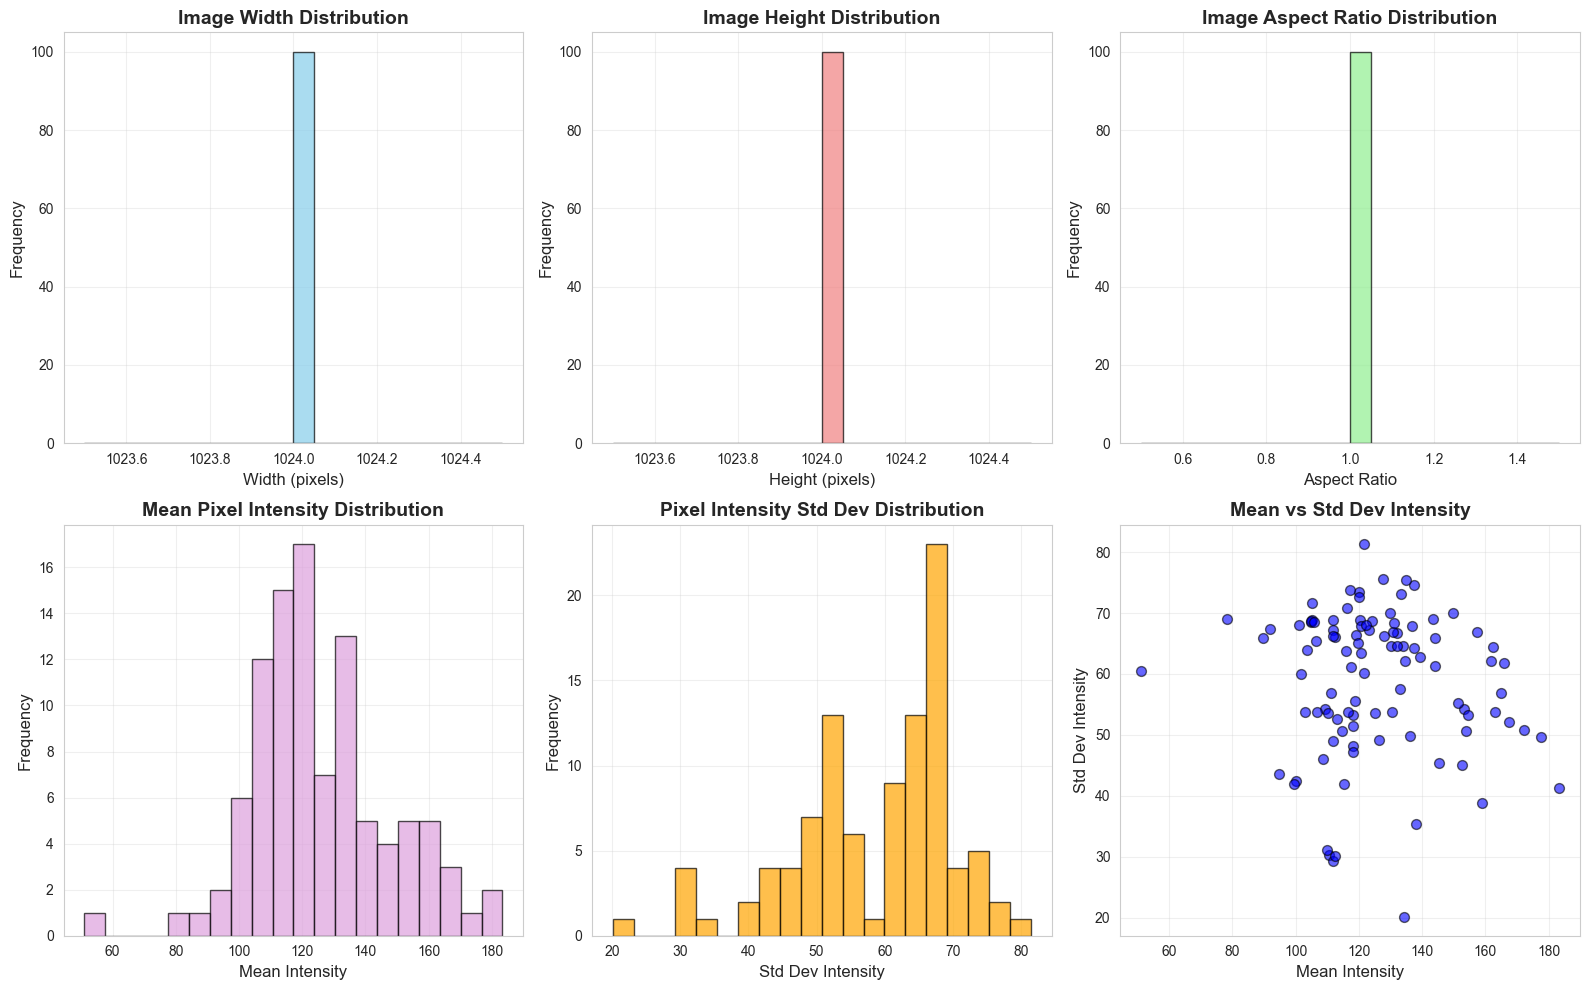


Image Statistics:
  Dimensions: 1024 x 1024 (most common)
  Width range: 1024 - 1024
  Height range: 1024 - 1024
  Mean intensity: 125.51 ± 22.07


In [63]:
# Image property analysis
eda.analyze_image_properties(num_samples=NUM_IMAGE_SAMPLES)